In [25]:
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [26]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import to_hex
from matplotlib.colorbar import ColorbarBase
import matplotlib.patches as mpatches
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
import matplotlib as mpl


In [27]:
plt.rcParams['xtick.labelsize'] = 22 # or whatever size you want
plt.rcParams['ytick.labelsize'] = 22 # or whatever size you want

# Set global font size for labels, titles and legends
plt.rcParams['axes.labelsize'] = 20# or whatever size you want
plt.rcParams['axes.titlesize'] = 20 # or whatever size you want
plt.rcParams['legend.fontsize'] = 16 # or whatever size you want
#plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True


In [28]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

mpl.rcParams['svg.fonttype'] = 'none'

In [29]:
# files and folders paths
file_name = "ap1_singlecell_experimental_data_filtered_fromAvgFreq_states.csv"
model_file = "ap1_calibrated_matched_parameters_initialConditions_states.csv"
ss_file = "ap1_calibrated_matched_model_steadystates.csv"
folder_path = "/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/experimental_data/"
model_folder = "/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/calibrated_data/"

In [6]:
# read data
ap1data = pd.read_csv(folder_path + file_name)
calibrated_data = pd.read_csv(model_folder + model_file)
calibrated_steadystate = pd.read_csv(model_folder + ss_file)
#ap1data.head()

## Figure 3 A: UMAP on calibrated parameters and experimental data (with recurrent AP-1 states)

### First, extract experimental data with recurrent AP-1 states

In [30]:
# what are the unique values of the cell_line column
cell_lines = ap1data.cell_line.unique()

# keep only three cell lines COLO858, LOXIMVI, and WM902B
#ap1data = ap1data[ap1data.cell_line.isin(['COLO858', 'LOXIMVI', 'WM902B'])]
# remove the time column since its all at 24 hours

# how many cells are there for each cell line for each replicate
ap1data.groupby(['cell_line', 'replicate_id']).size()


cell_line               replicate_id
A101D                   1               1819
                        2               1704
A2058                   1               2230
                        2               2438
A375                    1               5299
                        2               5784
A375 _x001A_NRAS(Q61K)  1               2899
                        2               3123
C32                     1               2271
                        2               2324
COLO858                 2               3058
HS294T                  1               1069
                        2               1247
IGR39                   1                894
                        2               1127
LOXIMVI                 1               4208
                        2               5067
MMACSF                  1               1989
                        2               2090
RVH421                  1                284
                        2                276
SKMEL19           

In [31]:
#### N
def sample_data(df, n_per_rep, consider_rep_id=True):
    # Sample n_per_rep cells from each replicate for each cell line
    sampled_dfs = []
    for cell_line in df['cell_line'].unique():
        cell_line_df = df[df['cell_line'] == cell_line]
        unique_reps = cell_line_df['replicate_id'].unique()
        if consider_rep_id:
            if len(unique_reps) == 1:
                # If only one replicate, sample n_per_rep * 2 from that replicate
                rep_df = cell_line_df[cell_line_df['replicate_id'] == unique_reps[0]]
                sampled_dfs.append(rep_df.sample(n=n_per_rep * 2, replace=False, random_state=42))
            else:
                for rep in unique_reps:
                    rep_df = cell_line_df[cell_line_df['replicate_id'] == rep]
                    sampled_dfs.append(rep_df.sample(n=n_per_rep, replace=False, random_state=42))  
        else:
            sampled_dfs.append(cell_line_df.sample(n=n_per_rep, replace=False, random_state=42))
    
    # Concatenate all sampled dataframes
    return pd.concat(sampled_dfs)
# sample data using the function above
#final_df = sample_data(ap1data, 276)
final_df = ap1data.copy()

# remove columns that contain 'state' in the name
final_df = final_df[final_df.columns[~final_df.columns.str.contains('state')]]
final_df

,cell_line,replicate_id,cFOS,cJUN,FRA1,FRA2,JUND
0,COLO858,2,7.147183,5.722960,6.525802,6.172763,6.597472
1,COLO858,2,6.765179,4.621774,7.161924,6.006806,6.549695
2,COLO858,2,6.739002,5.116043,6.817099,5.813044,6.904365
3,COLO858,2,6.337903,6.113940,7.113154,6.405335,6.856567
4,COLO858,2,6.676914,5.151108,7.158582,5.556220,7.034562
...,...,...,...,...,...,...,...
91310,WM115,2,6.663301,5.763291,5.178105,5.783043,6.007760
91311,WM115,2,5.753881,4.810865,5.445443,5.122947,6.065345
91312,WM115,2,5.879766,5.320457,5.078526,5.511158,6.110060
91313,WM115,2,5.750218,4.238472,5.397314,4.885684,5.913369


In [32]:
# add a column to final_df called source and set it to 'experimental'
final_df['source'] = 'experiment'
final_df



,cell_line,replicate_id,cFOS,cJUN,FRA1,FRA2,JUND,source
0,COLO858,2,7.147183,5.722960,6.525802,6.172763,6.597472,experiment
1,COLO858,2,6.765179,4.621774,7.161924,6.006806,6.549695,experiment
2,COLO858,2,6.739002,5.116043,6.817099,5.813044,6.904365,experiment
3,COLO858,2,6.337903,6.113940,7.113154,6.405335,6.856567,experiment
4,COLO858,2,6.676914,5.151108,7.158582,5.556220,7.034562,experiment
...,...,...,...,...,...,...,...,...
91310,WM115,2,6.663301,5.763291,5.178105,5.783043,6.007760,experiment
91311,WM115,2,5.753881,4.810865,5.445443,5.122947,6.065345,experiment
91312,WM115,2,5.879766,5.320457,5.078526,5.511158,6.110060,experiment
91313,WM115,2,5.750218,4.238472,5.397314,4.885684,5.913369,experiment


In [33]:
# scale data
scaler = StandardScaler()
columns_for_umap_and_diff_markers = ['cFOS', 'cJUN', 'FRA2', 'JUND', 'FRA1']
# Scale the data
final_df[columns_for_umap_and_diff_markers] = scaler.fit_transform(final_df[columns_for_umap_and_diff_markers])
final_df


,cell_line,replicate_id,cFOS,cJUN,FRA1,FRA2,JUND,source
0,COLO858,2,1.873889,-0.105433,0.455309,-0.178592,-0.373103,experiment
1,COLO858,2,0.968414,-1.318077,1.718156,-0.467574,-0.499951,experiment
2,COLO858,2,0.906366,-0.773780,1.033599,-0.804975,0.441705,experiment
3,COLO858,2,-0.044370,0.325120,1.621337,0.226389,0.314801,experiment
4,COLO858,2,0.759197,-0.735165,1.711521,-1.252187,0.787380,experiment
...,...,...,...,...,...,...,...,...
91310,WM115,2,0.726930,-0.061020,-2.220176,-0.857217,-1.938799,experiment
91311,WM115,2,-1.428690,-1.109847,-1.689448,-2.006651,-1.785909,experiment
91312,WM115,2,-1.130303,-0.548676,-2.417863,-1.330654,-1.667189,experiment
91313,WM115,2,-1.437372,-1.740175,-1.784996,-2.419801,-2.189408,experiment


### Extract Model Calibrated Parameters

In [34]:
calibrated_data

,Unnamed: 0,cell_line,param_index,init_cond_index,model_steadystate,input_state,(basal_fos).v,(basal_jun).v,(basal_fra1).v,(basal_fra2).v,...,(degradation_fos).k1,(degradation_jun).k1,(degradation_fra1).k1,(degradation_fra2).k1,(degradation_jund).k1,fos,jun,fra1,fra2,jund
0,0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,...,1.198298,1.226937,0.334726,0.217338,0.096315,179.255370,1.750838,1.379431,1.213148,78.016734
1,1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,...,1.198298,1.226937,0.334726,0.217338,0.096315,234.514312,9.810124,1.093112,6.614775,94.914584
2,2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,...,1.198298,1.226937,0.334726,0.217338,0.096315,111.734530,2.578653,1.458343,8.080196,66.645537
3,3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,...,1.198298,1.226937,0.334726,0.217338,0.096315,241.707260,1.288831,2.498698,0.740262,58.843376
4,4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,...,1.198298,1.226937,0.334726,0.217338,0.096315,28.665408,1.024603,1.226207,0.382405,10.112228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722113,722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,...,1.436447,1.416375,0.332745,0.159908,0.087497,15.457735,1.623207,15.652104,3.721252,18.812177
722114,722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,...,1.436447,1.416375,0.332745,0.159908,0.087497,135.414453,0.602182,30.314732,6.306824,110.328357
722115,722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,...,1.436447,1.416375,0.332745,0.159908,0.087497,29.226067,5.952171,67.973555,4.615749,163.346853
722116,722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,...,1.436447,1.416375,0.332745,0.159908,0.087497,106.223962,0.578846,58.061166,4.450853,81.673171


In [35]:
# from the cell_line column in calibrated_data, keep WM902B, LOXIMVI, and COLO858
calibrated_data_2 = calibrated_data.copy()
#calibrated_data_2 = calibrated_data[calibrated_data.cell_line.isin(['COLO858', 'LOXIMVI', 'WM902B'])]
# remove the unnamed column from calibrated_data
calibrated_data_2 = calibrated_data_2[calibrated_data_2.columns[~calibrated_data.columns.str.contains('Unnamed')]]
# include only COLO858, LOXIMVI, and WM902B in the calibrated_data
calibrated_data_2

,cell_line,param_index,init_cond_index,model_steadystate,input_state,(basal_fos).v,(basal_jun).v,(basal_fra1).v,(basal_fra2).v,(basal_jund).v,...,(degradation_fos).k1,(degradation_jun).k1,(degradation_fra1).k1,(degradation_fra2).k1,(degradation_jund).k1,fos,jun,fra1,fra2,jund
0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,179.255370,1.750838,1.379431,1.213148,78.016734
1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,234.514312,9.810124,1.093112,6.614775,94.914584
2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,111.734530,2.578653,1.458343,8.080196,66.645537
3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,241.707260,1.288831,2.498698,0.740262,58.843376
4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,28.665408,1.024603,1.226207,0.382405,10.112228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,15.457735,1.623207,15.652104,3.721252,18.812177
722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,135.414453,0.602182,30.314732,6.306824,110.328357
722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,29.226067,5.952171,67.973555,4.615749,163.346853
722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,106.223962,0.578846,58.061166,4.450853,81.673171


In [36]:
# Find intersecting param_index values between COLO858 and LOXIMVI
# these are bistale parameters that give rise to steady states that belong in both COLO858 and LOXIMVI
intersecting_param_index_COLO858_LOXIMVI = np.intersect1d(
    calibrated_data_2[calibrated_data_2.cell_line == 'COLO858'].param_index.unique(),
    calibrated_data_2[calibrated_data_2.cell_line == 'LOXIMVI'].param_index.unique()
)

# Remove intersecting_param_index from calibrated_data
calibrated_data_filtered = calibrated_data_2[~calibrated_data_2.param_index.isin(intersecting_param_index_COLO858_LOXIMVI)]

# no removing shared states between COLO858 and WM902B (they share a state so they should be kept)
# Find intersecting param_index values between COLO858 and WM902B
intersecting_param_index_COLO858_WM902B = np.intersect1d(
    calibrated_data_filtered[calibrated_data_filtered.cell_line == 'COLO858'].param_index.unique(),
    calibrated_data_filtered[calibrated_data_filtered.cell_line == 'WM902B'].param_index.unique()
)

# In the cell line column, label the intersecting_param_index as 'WM902B'
# calibrated_data_filtered.loc[
#     calibrated_data_filtered.param_index.isin(intersecting_param_index_COLO858_WM902B), 
#     'cell_line'
# ] = 'COLO858_WM902B'



In [61]:
# export calibrated_data_filtered to csv
#calibrated_data_filtered.to_csv('calibrated_data_parameters_initial_conditions_allcells_filtered.csv', index=False)

In [37]:
# extract the param_index column for the cell lines COL0858, LOXIMVI, and WM902B from calibrated_data_filtered in one dataframe

# Extract the param_index column for the cell lines COLO858, LOXIMVI, and WM902B
#param_cell_df = calibrated_data_filtered[calibrated_data_filtered.cell_line.isin(['COLO858', 'LOXIMVI', 'WM902B','COLO858_WM902B'])]
#drop duplicates based on param_index and cell_line
param_cell_df = calibrated_data_filtered.copy()
param_cell_df = param_cell_df.drop_duplicates(subset=['param_index', 'init_cond_index','cell_line']) # note the change here with keeping init_cond_index
param_cell_df

,cell_line,param_index,init_cond_index,model_steadystate,input_state,(basal_fos).v,(basal_jun).v,(basal_fra1).v,(basal_fra2).v,(basal_jund).v,...,(degradation_fos).k1,(degradation_jun).k1,(degradation_fra1).k1,(degradation_fra2).k1,(degradation_jund).k1,fos,jun,fra1,fra2,jund
0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,179.255370,1.750838,1.379431,1.213148,78.016734
1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,234.514312,9.810124,1.093112,6.614775,94.914584
2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,111.734530,2.578653,1.458343,8.080196,66.645537
3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,241.707260,1.288831,2.498698,0.740262,58.843376
4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,28.665408,1.024603,1.226207,0.382405,10.112228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,15.457735,1.623207,15.652104,3.721252,18.812177
722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,135.414453,0.602182,30.314732,6.306824,110.328357
722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,29.226067,5.952171,67.973555,4.615749,163.346853
722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,106.223962,0.578846,58.061166,4.450853,81.673171


In [38]:
# keep only the cell lines COLO858, LOXIMVI, and WM902B from calibrated_steadystate
#calibrated_steadystate = calibrated_steadystate[calibrated_steadystate.cell_line.isin(['COLO858', 'LOXIMVI', 'WM902B'])]
# remove the Unnamed column from calibrated_steadystate
calibrated_steadystate = calibrated_steadystate[calibrated_steadystate.columns[~calibrated_steadystate.columns.str.contains('Unnamed')]]
calibrated_steadystate

,cell_line,param_index,init_cond_index,model_steadystate_x,input_state,fos,jun,fra1,fra2,jund,model_steadystate_y
0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high",26.2,0.4,7.1,4.6,13.3,"high,low,low,low,high"
1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high",26.2,0.4,7.1,4.6,13.3,"high,low,low,low,high"
2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high",26.2,0.4,7.1,4.6,13.3,"high,low,low,low,high"
3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high",26.2,0.4,7.1,4.6,13.3,"high,low,low,low,high"
4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high",26.2,0.4,7.1,4.6,13.3,"high,low,low,low,high"
...,...,...,...,...,...,...,...,...,...,...,...
722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",22.6,0.2,24.8,8.9,10.8,"high,low,high,low,high"
722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",22.6,0.2,24.8,8.9,10.8,"high,low,high,low,high"
722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",22.6,0.2,24.8,8.9,10.8,"high,low,high,low,high"
722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",22.6,0.2,24.8,8.9,10.8,"high,low,high,low,high"


In [41]:
# Filter calibrated_steadystate to match param_cell_df's combinations
filtered_steadystate = calibrated_steadystate.merge(
    param_cell_df[['param_index', 'init_cond_index', 'cell_line']],
    on=['param_index', 'init_cond_index', 'cell_line'],
    how='inner'
)
# rename the columns fos, jun, fra1, fra2, jund to cFOS, cJUN, FRA1, FRA2, JUND
filtered_steadystate.rename(columns={'fos': 'cFOS', 'jun': 'cJUN', 'fra1': 'FRA1', 'fra2': 'FRA2', 'jund': 'JUND'}, inplace=True)
# only keep the columns cell_line, cFOS, cJUN, FRA1, FRA2, JUND
filtered_steadystate = filtered_steadystate[['cell_line', 'cFOS', 'cJUN', 'FRA1', 'FRA2', 'JUND']]

# add a column to filtered_steadystate called source and set it to 'model'
# convert the data to log10 for cFOS, cJUN, FRA1, FRA2, JUND
filtered_steadystate['cFOS'] = np.log10(filtered_steadystate['cFOS'])
filtered_steadystate['cJUN'] = np.log10(filtered_steadystate['cJUN'])
filtered_steadystate['FRA1'] = np.log10(filtered_steadystate['FRA1'])
filtered_steadystate['FRA2'] = np.log10(filtered_steadystate['FRA2'])
filtered_steadystate['JUND'] = np.log10(filtered_steadystate['JUND'])
filtered_steadystate['source'] = 'model'
filtered_steadystate


,cell_line,cFOS,cJUN,FRA1,FRA2,JUND,source
0,A101D,1.418301,-0.39794,0.851258,0.662758,1.123852,model
1,A101D,1.418301,-0.39794,0.851258,0.662758,1.123852,model
2,A101D,1.418301,-0.39794,0.851258,0.662758,1.123852,model
3,A101D,1.418301,-0.39794,0.851258,0.662758,1.123852,model
4,A101D,1.418301,-0.39794,0.851258,0.662758,1.123852,model
...,...,...,...,...,...,...,...
721178,WM902B,1.354108,-0.69897,1.394452,0.949390,1.033424,model
721179,WM902B,1.354108,-0.69897,1.394452,0.949390,1.033424,model
721180,WM902B,1.354108,-0.69897,1.394452,0.949390,1.033424,model
721181,WM902B,1.354108,-0.69897,1.394452,0.949390,1.033424,model


In [42]:
# drop duplicates based on cell_line cFOS, cJUN, FRA1, FRA2, JUND
# makes sense to remove duplicates here
filtered_steadystate = filtered_steadystate.drop_duplicates(subset=['cell_line', 'cFOS', 'cJUN', 'FRA1', 'FRA2', 'JUND'])
filtered_steadystate


,cell_line,cFOS,cJUN,FRA1,FRA2,JUND,source
0,A101D,1.418301,-0.397940,0.851258,0.662758,1.123852,model
5,A101D,1.515874,0.000000,0.903090,0.278754,1.100371,model
10,A101D,1.025306,-0.301030,0.924279,0.000000,1.416641,model
15,A101D,1.000000,-0.397940,0.944483,0.342423,1.093422,model
20,A101D,1.752048,-0.154902,0.903090,0.477121,1.255273,model
...,...,...,...,...,...,...,...
720096,WM902B,1.742725,-0.096910,1.537819,-0.154902,1.093422,model
720130,WM902B,1.517196,-0.096910,1.340444,0.672098,1.136721,model
720296,WM902B,1.359835,-0.698970,1.909556,0.176091,1.303196,model
720382,WM902B,1.748188,-0.698970,1.416641,0.991226,1.301030,model


In [44]:
# zscore filtered_steadystate
# scale data
model_scaler = StandardScaler()
columns_for_umap_and_diff_markers = ['cFOS', 'cJUN', 'FRA2', 'JUND', 'FRA1']
# Scale the data
filtered_steadystate[columns_for_umap_and_diff_markers] = model_scaler.fit_transform(filtered_steadystate[columns_for_umap_and_diff_markers])
filtered_steadystate

/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_39833/501890985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_steadystate[columns_for_umap_and_diff_markers] = model_scaler.fit_transform(filtered_steadystate[columns_for_umap_and_diff_markers])


,cell_line,cFOS,cJUN,FRA1,FRA2,JUND,source
0,A101D,1.427968,-0.642344,-0.438540,0.674055,-0.908298,model
5,A101D,1.556031,0.022844,-0.352888,-0.218271,-1.020030,model
10,A101D,0.912165,-0.480351,-0.317873,-0.866022,0.484896,model
15,A101D,0.878951,-0.642344,-0.284487,-0.070321,-1.053095,model
20,A101D,1.866008,-0.236087,-0.352888,0.242683,-0.282951,model
...,...,...,...,...,...,...,...
720096,WM902B,1.853771,-0.139149,0.696004,-1.225974,-1.053095,model
720130,WM902B,1.557766,-0.139149,0.369841,0.695758,-0.847063,model
720296,WM902B,1.351232,-1.145539,1.310301,-0.456832,-0.054913,model
720382,WM902B,1.860941,-1.145539,0.495756,1.437329,-0.065220,model


In [45]:
# only keep the columns cell_line, cFOS, cJUN, FRA1, FRA2, JUND, source from final_df
final_df = final_df[['cell_line', 'cFOS', 'cJUN', 'FRA1', 'FRA2', 'JUND', 'source']]
final_df


,cell_line,cFOS,cJUN,FRA1,FRA2,JUND,source
0,COLO858,1.873889,-0.105433,0.455309,-0.178592,-0.373103,experiment
1,COLO858,0.968414,-1.318077,1.718156,-0.467574,-0.499951,experiment
2,COLO858,0.906366,-0.773780,1.033599,-0.804975,0.441705,experiment
3,COLO858,-0.044370,0.325120,1.621337,0.226389,0.314801,experiment
4,COLO858,0.759197,-0.735165,1.711521,-1.252187,0.787380,experiment
...,...,...,...,...,...,...,...
91310,WM115,0.726930,-0.061020,-2.220176,-0.857217,-1.938799,experiment
91311,WM115,-1.428690,-1.109847,-1.689448,-2.006651,-1.785909,experiment
91312,WM115,-1.130303,-0.548676,-2.417863,-1.330654,-1.667189,experiment
91313,WM115,-1.437372,-1.740175,-1.784996,-2.419801,-2.189408,experiment


### Merge and perfrom UMAP analysis

In [46]:
# concatenate filtered_steadystate and final_df
combined_df = pd.concat([filtered_steadystate, final_df])
# only keep the cell_lines COLO858, LOXIMVI, and WM902B from combined_df
#combined_df = combined_df[combined_df['cell_line'].isin(['COLO858', 'LOXIMVI', 'WM902B'])]
combined_df


,cell_line,cFOS,cJUN,FRA1,FRA2,JUND,source
0,A101D,1.427968,-0.642344,-0.438540,0.674055,-0.908298,model
5,A101D,1.556031,0.022844,-0.352888,-0.218271,-1.020030,model
10,A101D,0.912165,-0.480351,-0.317873,-0.866022,0.484896,model
15,A101D,0.878951,-0.642344,-0.284487,-0.070321,-1.053095,model
20,A101D,1.866008,-0.236087,-0.352888,0.242683,-0.282951,model
...,...,...,...,...,...,...,...
91310,WM115,0.726930,-0.061020,-2.220176,-0.857217,-1.938799,experiment
91311,WM115,-1.428690,-1.109847,-1.689448,-2.006651,-1.785909,experiment
91312,WM115,-1.130303,-0.548676,-2.417863,-1.330654,-1.667189,experiment
91313,WM115,-1.437372,-1.740175,-1.784996,-2.419801,-2.189408,experiment


In [47]:
# count the number of samples in combined_df
combined_df.groupby(['cell_line', 'source']).size()


cell_line               source    
A101D                   experiment     3523
                        model          2759
A2058                   experiment     4668
                        model          2134
A375                    experiment    11083
                        model          2663
A375 _x001A_NRAS(Q61K)  experiment     6022
A375_NRAS(Q61K)         model          1497
C32                     experiment     4595
                        model          1587
COLO858                 experiment     3058
                        model          1450
HS294T                  experiment     2316
                        model          1158
IGR39                   experiment     2021
                        model          1211
LOXIMVI                 experiment     9275
                        model           180
MMACSF                  experiment     4079
                        model          2759
RVH421                  experiment      560
                        model          14

In [48]:
# Create a balanced dataset with equal number of points from each cell line and source
# Since we have more cells in the experimental data, we will downsample the experimental data to match the model data
balanced_df = pd.DataFrame()

# Get the count of samples for each cell line and source
example_cell_line = ['COLO858', 'LOXIMVI', 'WM902B','WM115']
sample_counts = {}
all_cells = combined_df['cell_line'].unique()
for cell_line in example_cell_line:
    # Count model samples for this cell line
    model_count = len(combined_df[(combined_df['cell_line'] == cell_line) & 
                                (combined_df['source'] == 'model')])
    # Count experimental samples for this cell line
    exp_count = len(combined_df[(combined_df['cell_line'] == cell_line) & 
                              (combined_df['source'] == 'experiment')])
    
    # Use the minimum count for both sources
    sample_counts[cell_line] = min(model_count, exp_count)
    print(f"Using {sample_counts[cell_line]} samples for {cell_line}")

# Sample equal numbers from each cell line and source
for cell_line in example_cell_line:
    for source in ['model', 'experiment']:
        subset = combined_df[(combined_df['cell_line'] == cell_line) & 
                          (combined_df['source'] == source)]
        
        # If we have enough samples, take a random sample
        if len(subset) >= sample_counts[cell_line]:
            sampled = subset.sample(n=sample_counts[cell_line], random_state=42)
        else:
            # If we don't have enough, take all available samples
            sampled = subset
            
        balanced_df = pd.concat([balanced_df, sampled])
balanced_df

Using 1450 samples for COLO858
Using 180 samples for LOXIMVI
Using 519 samples for WM902B
Using 1115 samples for WM115


,cell_line,cFOS,cJUN,FRA1,FRA2,JUND,source
283319,COLO858,0.633401,0.561458,-0.171530,-0.526459,0.387629,model
284812,COLO858,-0.560734,-1.145539,0.093447,0.426680,0.015830,model
279916,COLO858,-0.724715,-0.851189,0.429551,-1.225974,-1.416578,model
289160,COLO858,1.235741,0.743902,-0.061897,-0.166507,-1.138149,model
280555,COLO858,-0.955834,-0.347994,0.053841,0.398250,-1.416578,model
...,...,...,...,...,...,...,...
91059,WM115,-0.595827,-1.120458,-1.156526,-1.674436,-1.587007,experiment
88792,WM115,-0.404289,0.055133,-0.660637,-1.360777,-1.884321,experiment
89556,WM115,0.108995,-0.464033,-0.743182,-1.188167,-0.067750,experiment
89448,WM115,0.056116,-0.349891,-1.796241,-0.905898,-0.442583,experiment


In [ ]:
# # scale data
# scaler = StandardScaler()
# columns_for_umap_and_diff_markers = ['cFOS', 'cJUN', 'FRA1', 'FRA2', 'JUND']
# # Scale the data
# combined_df[columns_for_umap_and_diff_markers] = scaler.fit_transform(combined_df[columns_for_umap_and_diff_markers])
# combined_df

In [49]:
columns_for_umap = ['cFOS', 'cJUN', 'FRA2', 'JUND', 'FRA1']

# Prepare the UMAP reducer
umap_reducer = UMAP(n_neighbors =50, min_dist=0.5, n_components=2, random_state=42, metric='euclidean')

# Fit UMAP using the entire dataset
umap_result = umap_reducer.fit_transform(balanced_df[columns_for_umap])

# Add the UMAP results back into the DataFrame
balanced_df['UMAP1'] = umap_result[:, 0]
balanced_df['UMAP2'] = umap_result[:, 1]

/Users/njr7jk/opt/anaconda3/envs/ap1_proj/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


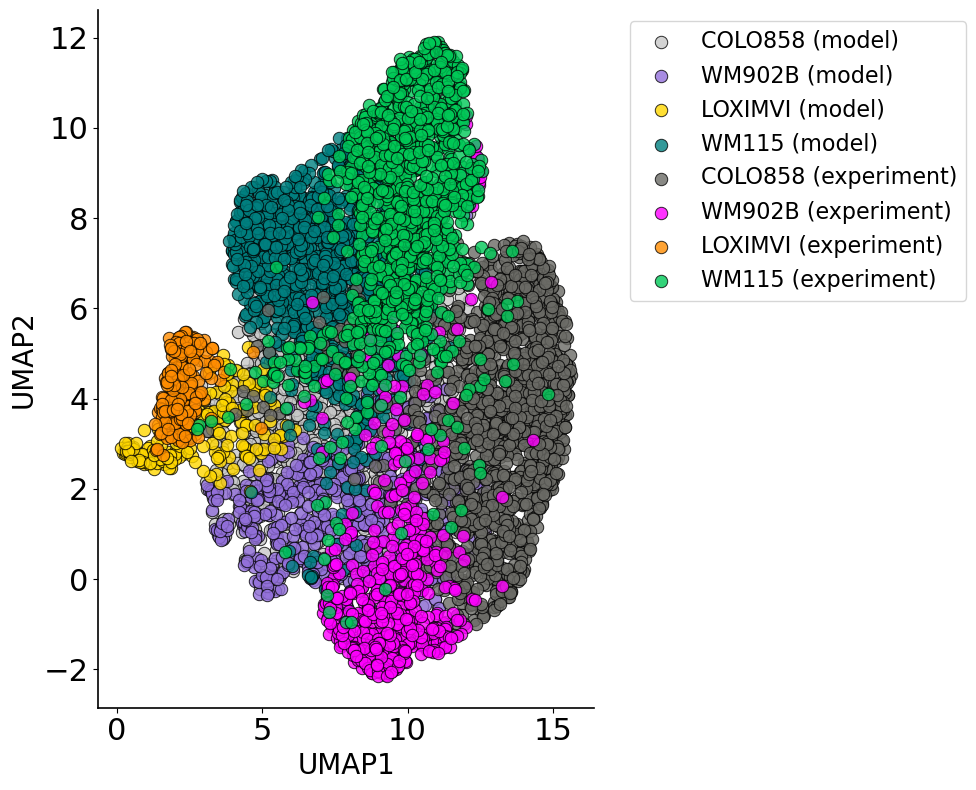

In [50]:
# Define custom colors for each cell line - base colors
custom_palette = {
    'COLO858': '#4C4C47',  # Gray
    'WM902B': 'violet',
    'LOXIMVI': 'orange',
    'WM115': '#4169E1'
}

# Create hot (experimental) and cool (model) variants for each color
hot_cool_palette = {}
for cell_line, color in custom_palette.items():
    # Create hot variant for experimental data
    hot_cool_palette[(cell_line, 'experiment')] = f"hot{color}" if color != '#4C4C47' else '#6B6B66'
    # Create cool variant for model data
    hot_cool_palette[(cell_line, 'model')] = f"cool{color}" if color != '#4C4C47' else '#3D3D39'

# Set a default color for other cell lines
default_color_exp = 'lightcoral'  # Hot variant for experimental
default_color_model = 'lightblue'  # Cool variant for model
default_alpha = 0.2

# Create a scatter plot of the UMAP results
plt.figure(figsize=(10, 8))

# Plot the data by cell line and source
for source in ['model', 'experiment']:
    # First plot the other cell lines with default color
    other_cells = balanced_df[(~balanced_df['cell_line'].isin(custom_palette.keys())) & 
                           (balanced_df['source'] == source)]
    if not other_cells.empty:
        sns.scatterplot(
            x='UMAP1', 
            y='UMAP2', 
            data=other_cells, 
            color=default_color_model if source == 'model' else default_color_exp, 
            marker='o',
            label=f'Other ({source})',
            s=50,
            alpha=default_alpha
        )
    
    # Then plot the specified cell lines with their hot/cool colors
    for cell_line in custom_palette.keys():
        subset = balanced_df[(balanced_df['cell_line'] == cell_line) & 
                          (balanced_df['source'] == source)]
        if not subset.empty:
            # Use proper hot/cool color variant
            if source == 'experiment':
                if cell_line == 'COLO858':
                    color = '#6B6B66'  # Warmer gray
                elif cell_line == 'WM902B':
                    color = 'magenta'  # Hotter violet
                elif cell_line == 'LOXIMVI':
                    color = 'darkorange'
                elif cell_line == 'WM115':
                    color = '#00C957' # emerald green
            else:  # model
                if cell_line == 'COLO858':
                    color = '#C8C8C8'  # Cooler gray
                elif cell_line == 'WM902B':
                    color = 'mediumpurple'  # Cooler violet
                elif cell_line == 'LOXIMVI':
                    color = 'gold'  # Cooler orange
                elif cell_line == 'WM115':
                    color = '#008080' # teal
                
            sns.scatterplot(
                x='UMAP1', 
                y='UMAP2', 
                data=subset, 
                color=color, 
                edgecolor='black',
                marker='o',  # Use same marker
                label=f'{cell_line} ({source})',
                s=80,
                alpha=0.8
            )

# Add title and labels
plt.title('')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Show the plot with a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#save pdf file
#plt.savefig('Fig3A_Updated_calibrated_UMAP_combined_model_experimental_WM115_more_samples.pdf', dpi=300)

plt.show()